<a href="https://colab.research.google.com/github/hhhgggaaa/try/blob/main/Yutong_Zhao_Data_Bootcamp_Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Should You Enter the Healthy Fast-Casual Dining Industry in New York Now?**

## An analytical report based on economic indicators, consumer trends, and restaurant-level data

### **Introduction**

**Social and Industry Background**

Over the past decade, especially after the COVID-19 pandemic, the relationship between food, health, and lifestyle has changed dramatically in the United States. Consumers are increasingly aware of the connection between nutrition and long-term well-being. The demand for food that is fresh, convenient, and healthy has accelerated across major cities, driven by younger professionals, fitness-oriented millennials, and urban consumers who balance busy schedules with wellness goals. This social background has transformed the restaurant landscape. The fast-casual segment—typified by chains like Chipotle Mexican Grill, Sweetgreen, Dig Inn, and CAVA—now sits between traditional fast food and full-service dining. The “healthy” subsegment (grain bowls, salads, protein-plus-vegetable combinations) captures the overlap of affordability, speed, and wellness. Yet success is uneven: many entrants thrive briefly before facing intense rivalry and rising costs.

Thus, the key strategic question is whether now is the right time to enter the healthy fast-casual dining industry in New York.

**Purpose of the analysis**

The goal of this project is to use data-driven evidence to evaluate the current attractiveness of the New York healthy fast-casual market and to develop a clear, reproducible reasoning framework for decision-making. The analysis applies Porter's Five Forces Stategic Model, aiming to investigate the New York fast-casual industry by analyzing the buyer power and demands, supplier power, threat of substitutes, and current competition, then connects those results to entry strategies.

**Data Source**

Restaurant-level data (from Yelp Developers): combined_fast_casual

Include observations with features such as restaurant name, location (latitude, longitude, city), price level, rating, review count, and category.

Macroeconomic indicators (from FRED API):

CPI (Consumer Price Index): Food Away From Home, Food At Home

PPI (Producer Price Index): Farm Products

Sales: Limited-service Eating Places, Food Services & Drinking Places

Financial statements of incumbents (from Yahoo Finance): final_df

Google Trends


**Analytical methods:**

Exploratory data visualization: spatial density heatmap, bar charts, time-series line graphs.

Correlation analysis: linking price levels and customer ratings to understand price sensitivity.

ZIP code ranking: aggregated and normalized metrics (competitors, total reviews, average ratings) were used to compute a weighted score for each ZIP code to identify high-potential trade areas.


In [1]:
# --- Import necessary libraries ---
import pandas as pd
import requests
import json
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Category10
from bokeh.layouts import column
output_notebook()

## **Yelp Fast Casual Dining Industry Data Collection**

The aim here is to identify and extact a dataset of fast casual and health-focused restaurants in New York. I extrcted restaurants data that match the selected key words for healthy fast casual restaurants from Yelp Developers. The key words include: "Fast Casual, Healthy,Wraps, Bowls, Build-your-own, Sandwiches, Salad,Burritos, Gluten-Free, Fresh,Organic, Green, Natural, Wholesome, Grains, Protein, Vegetarian". To have more comprehensive data, I also extract data for the main healthy fast_casual chains in New York, including "Chipotle Mexican Grill", "Panera Bread", "Dig Inn", "fresh&co", "Qdoba Mexican Eats", "sweetgreen", "CAVA", "Just Salad", "Saladworks", "Bibibop Asian Grill","Playa Bowls", "Toastique","Chopt","NAYA". The combination of these two data sets forms an approximately comprehensive fast_casual dining industry in New york, which can provide information for analyzing trends, customer demands, and competition in this industry.

In [ ]:
# --- Yelp API authentication setup ---
# Yelp API Key
YELP_API_KEY = "CvB1sBzC6oHVXL3tzfGiEyPG9rALoKHj11mt3g0RDPAvVxzdGkCe3pi1E5jGPIj8NRlB-q2tZVDUST1JgFPU_pSX51PCaHd3Fc87MSESkwrvTytyKssXkL7gab_naHYx"

# --- Define request headers with API key for authentication ---
HEADERS = {"Authorization": f"Bearer {YELP_API_KEY}"}  # Required header format for Yelp API

# --- Yelp Business Search endpoint ---
yelp_url = "https://api.yelp.com/v3/businesses/search"

In [ ]:
# --- Define search parameters for the Yelp API ---
limit = 50                 # Maximum number of businesses per request (Yelp limit)
offset = 0                 # Used for pagination (fetch results beyond the first 50)
all_fast_casual = []       # Initialize an empty list to store results

# --- Define keyword filter for relevant restaurant categories ---
# These keywords help identify restaurants that fit the "fast casual" or "healthy" profile.
keywords = ("Fast Casual|Healthy|Wraps|Bowls|Build-your-own|Sandwiches|Salad|"
            "Burritos|Gluten-Free|Fresh|Organic|Green|Natural|Wholesome|Grains|"
            "Protein|Vegetarian")

# --- Begin data collection loop with pagination ---
while True:
    # --- Define parameters for Yelp API search request ---
    params = {
        "location": "NY",             # Limit search to New York
        "categories": "restaurants",  # Restrict results to the restaurant category
        "term": "Fast Casual",        # Search term to target fast casual dining
        "sort_by": "rating",          # Sort results by Yelp rating (highest first)
        "limit": limit,               # Number of businesses per request (max = 50)
        "offset": offset}             # Pagination offset (starts at 0)

    # Send request to Yelp API
    response = requests.get(yelp_url, headers=HEADERS, params=params)
    data = response.json()   # Parse response as JSON format

    # --- Extract list of businesses from the JSON response ---
    businesses = data.get("businesses", [])

    # --- If no more results are returned, exit the loop ---
    if not businesses:
        break

    # --- Extract and store relevant fields for each business ---
    for biz in businesses:
        all_fast_casual.append({
            "name": biz["name"],
            "rating": biz.get("rating"),
            "review_count": biz.get("review_count"),
            "city": biz["location"]["city"],
            "zip_code": biz["location"]["zip_code"],
            "state": biz["location"]['state'],
            "category": ", ".join([c["title"] for c in biz["categories"]]),
            "price": biz.get("price", "N/A"),
            "address": biz["alias"],
            "latitude": biz["coordinates"]["latitude"],
            "longitude": biz["coordinates"]["longitude"]})

    # --- Move to the next page of results ---
    offset += limit

# --- Convert collected data into a DataFrame for analysis ---
filter_df = pd.DataFrame(all_fast_casual)

# --- Filter results by relevant keywords in restaurant categories ---
# Keeps only restaurants whose categories match terms like “Salad,” “Healthy,” or “Bowls”
filter_fast_casual_df = filter_df[filter_df["category"].str.contains(keywords, case=False, na=False)]

# --- Display results ---
print(f"Filtered fast casual restaurants fetched: {len(filter_fast_casual_df)}")
filter_fast_casual_df.head(20)


Filtered fast casual restaurants fetched: 66


,name,rating,review_count,city,zip_code,state,category,price,address,latitude,longitude
4,Tamam,4.7,255,New York,10075,NY,"Falafel, Vegetarian, Gluten-Free",N/A,tamam-new-york-3,40.773968,-73.959793
5,Kati Shop,4.7,227,New York,10022,NY,"Thai, Gluten-Free, Salad",$$,kati-shop-new-york-7,40.758990,-73.968830
9,Forma Pasta Factory,4.6,340,Brooklyn,11238,NY,"Italian, Pasta Shops, Salad",$$,forma-pasta-factory-brooklyn-3,40.686023,-73.973142
10,Nurish,4.6,148,Brooklyn,11238,NY,"Salad, Breakfast & Brunch, Cafes",$$,nurish-brooklyn-2,40.678340,-73.963630
12,The Independent Cafe,4.6,9,New York,10023,NY,"Desserts, Coffee & Tea, Sandwiches",N/A,the-independent-cafe-new-york-2,40.771110,-73.982846
15,Butterflied Chicken,4.5,55,New York,10036,NY,"Greek, Salad, Beer, Wine & Spirits",$$,butterflied-chicken-new-york-2,40.755790,-73.980640
16,Smør,4.5,236,New York,10009,NY,"Scandinavian, Sandwiches, Breakfast & Brunch",$$,smør-new-york,40.729352,-73.981664
18,Miriam Street Food,4.5,32,Brooklyn,11217,NY,"Mediterranean, Sandwiches, Breakfast & Brunch",N/A,miriam-street-food-brooklyn-2,40.680116,-73.977748
20,Shawarma Mia,4.5,89,Brooklyn,11217,NY,"Turkish, Mediterranean, Wraps",N/A,shawarma-mia-brooklyn,40.680602,-73.974396
26,Banter,4.4,201,New York,10014,NY,"Breakfast & Brunch, Coffee & Tea, Acai Bowls",$$,banter-new-york-3,40.739120,-74.005616


In [ ]:

# --- Yelp API parameters ---
limit = 50            # Maximum number of businesses per request in Yelp

# --- Brands name for filtering ---
BRANDS = [
    "Chipotle Mexican Grill", "Panera Bread", "Dig Inn", "Fresh & Co","fresh&co",
    "Qdoba Mexican Eats", "QDOBA Mexican Eats","sweetgreen", "Sweetgreen","CAVA", "Just Salad", "Saladworks",
    "Naya","Bibibop Asian Grill","Playa Bowls","Toastique","Chopt","NAYA"]

# --- Initialize an empty list to store results ---
main_fast_casual = []

# --- Loop through each fast-casual brand to fetch Yelp business data ---
for brand in BRANDS:
    offset = 0      # Used for pagination (fetch results beyond the first 50)

    while True:
        # --- Define search parameters for the Yelp API ---
        params = {
            "location": "NY",              # Limit search to New York
            "categories": "restaurants",   # Restrict to restaurant category
            "term": brand,                 # Search term: restaurant brand name
            "sort_by": "rating",           # Sort results by rating (descending)
            "limit": limit,                # Number of results per request
            "offset": offset}              # Pagination offset

        # --- Send request to Yelp API ---
        response = requests.get(yelp_url, headers=HEADERS, params=params)
        main_data = response.json()  # Convert response to JSON
        businesses = main_data.get("businesses", [])  # Extract business list

        # --- Break loop if no businesses are returned ---
        if not businesses:
            break

       # --- Extract relevant fields for each business ---
        for biz in businesses:
            main_fast_casual.append({
                "name": biz["name"],
                "rating": biz.get("rating"),
                "review_count": biz.get("review_count"),
                "state": biz["location"]["state"],
                "city": biz["location"]["city"],
                "zip_code": biz["location"]["zip_code"],
                "category": ", ".join([c["title"] for c in biz["categories"]]),
                "price": biz.get("price", "N/A"),
                "address": biz["alias"],  # Yelp alias as a unique identifier
                "latitude": biz["coordinates"]["latitude"],
                "longitude": biz["coordinates"]["longitude"]})

# --- Move to the next page of results ---
        offset += limit

# --- Convert collected data into a DataFrame ---
main_df = pd.DataFrame(main_fast_casual)

# --- Filter: keep only the targeted brands and New York locations ---
pattern = "|".join(BRANDS)
main_fast_casual_df = main_df[
    (main_df["name"].str.contains(pattern, case=False, na=False)) &
    (main_df["state"] == "NY")]

# --- Display results ---
print(f"Total main fast casual restaurants in NY fetched: {len(main_fast_casual_df)}")
main_fast_casual_df.head(20)

In [ ]:
# Combine the two DataFrames
combined_fast_casual = pd.concat([filter_fast_casual_df, main_fast_casual_df], ignore_index=True)

# Remove duplicates
combined_fast_casual = combined_fast_casual.drop_duplicates(subset=['name', 'address']).reset_index(drop=True)

## **1.Buyer Power Analysis - Price Sensitivity**

**Purpose:**

To measure how customer ratings vary with restaurant pricing, providing insight into the price sensitivity of consumers in the fast-casual segment. A negative correlation suggests that higher-priced restaurants tend to receive lower ratings (indicating higher price sensitivity), while a positive correlation indicates lower sensitivity or stronger brand value at higher price points.

**Data Source:**

Yelp Developer - combined_fast_casual

**Interpretation:**

Due to Yelp's filter settings, every time it will generate a slightly different groups of restaurants. So I ran it for 20 times and take the average of the correlation between price and rating. The result 0.44 shows a moderate positive correlation. This means that as price increases, the rating tends to be higher on average, suggesting that customers are willing to pay for quality, low price alone doesn’t guarantee satisfaction. Customers in this industry value health, convenience, and taste more than cheapness. Buyer power is moderate to low in this context. Customers care about quality and are not really price-sensitive.

In [ ]:
# --- Remove entries without price info ---
# Make a copy of the combined dataset to preserve the original
combined_fast_casual_withprice = combined_fast_casual.copy()

# Keep only rows where 'price' is available (exclude 'N/A')
combined_fast_casual_withprice = combined_fast_casual_withprice[
    combined_fast_casual_withprice["price"] != "N/A"]

# --- Map price symbols to numeric values for analysis ---
# Convert price symbols to numbers
price_to_num = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}

# Create a new column 'price_num' with numeric values (1–4)
combined_fast_casual_withprice['price_num'] = (
    combined_fast_casual_withprice['price'].map(price_to_num))

# --- Compute correlation between price and rating ---
# Measures how strongly Yelp rating relates to price level
# Positive correlation → higher-priced restaurants tend to have higher ratings
# Negative correlation → higher-priced restaurants tend to have lower ratings
corr = combined_fast_casual_withprice[['price_num', 'rating']].corr().iloc[0, 1]

# --- Display the result ---
print(f"Correlation (price vs rating): {corr:.2f}")


Correlation (price vs rating): 0.42


## **2.Demand and Trends Analysis**

**Purpose:**

This section investigates demand patterns and consumer behavior in the U.S. restaurant industry, using a combination of economic indicators, search interest data, and price dynamics.
The goal is to capture both how much people spend (sales growth) and how their preferences evolve (Google Trends), while also understanding cost-side pressures (CPI inflation) that influence both consumers and operators.

### 2.1 Economic Demand — Sales Trends

**Data Source:**

FRED (Federal Reserve Economic Data)

Series ID SM72251XUSN: Limited-Service Eating Places

Series ID MRTSSM722USS: Food Services & Drinking Places

**Interpretation:**

Both datasets show a steady upward trend from 2021 to 2024, confirming consistent recovery and expansion in the restaurant sector.

Limited-service restaurants (fast casual+fast) demonstrate stronger and more stable growth, reflecting consumer preference for affordable, convenient options amid inflation and lifestyle shifts.

Overall, the data highlights a resilient demand base and a positive long-term growth trajectory for the fast casual segment.

In [2]:
# --- Install and import required library ---
!pip install fredapi
from fredapi import Fred

# --- Initialize FRED API connection ---
fred = Fred(api_key="027ebcbd569f20d0871f8abdc6f4ed69")

In [3]:
# --- Define the FRED series for "Limited-Service Eating Places" ---
# This series (SM72251XUSN) represents U.S. monthly sales in millions of dollars
series_id_limited = "SM72251XUSN"

# --- Fetch monthly data from FRED ---
limited_df = fred.get_series(series_id_limited).to_frame(name="sales_millions")

# Convert the index to datetime for time-series analysis
limited_df.index = pd.to_datetime(limited_df.index)

# --- Filter data for years 2021–2024 only ---
limited_df = limited_df[limited_df.index.year >= 2021]

# --- Compute annual totals by summing 12 monthly values per year ---
limited_df_yearly = limited_df.resample("YE").sum()

# Replace the DatetimeIndex with just the year for clarity
limited_df_yearly.index = limited_df_yearly.index.year

# --- Drop incomplete data for 2025 ---
limited_df_yearly = limited_df_yearly[limited_df_yearly.index != 2025]

# --- Compute Year-over-Year (YoY) growth in percentage terms ---
limited_df_yearly["yoy_growth_%"] = limited_df_yearly["sales_millions"].pct_change() * 100

# --- Display annual summary table ---
print("\n=== Annual Sales: Limited-Service Eating Places (Millions USD) ===")
print(limited_df_yearly.round(2), "\n\n")

# --- Prepare data for visualization (convert index to column for Bokeh) ---
source = ColumnDataSource(limited_df.reset_index().rename(columns={'index': 'Date'}))

# --- Create interactive line chart ---
limited_service_p = figure(
    title="U.S. Monthly Sales — Limited-Service Eating Places 2021–2025 October",
    x_axis_type="datetime",         # Interpret x-axis as dates
    x_axis_label="Date",
    y_axis_label="Sales (Millions USD)",
    width=1000, height=600,
    tools="pan,wheel_zoom,box_zoom,reset,save")

# --- Add line and scatter markers to the plot ---
limited_service_p.line(
    'Date', 'sales_millions',
    source=source,
    line_width=4, color="orange",
    legend_label="Sales")

limited_service_p.scatter(
    'Date', 'sales_millions',
    source=source,
    size=9, marker="circle",
    color="orange", alpha=0.7)

# --- Add hover tool to display details interactively ---
hover = HoverTool(
    tooltips=[
        ("Date", "@Date{%Y-%m}"),
        ("Sales", "@sales_millions{0,0} M USD")],
    formatters={'@Date': 'datetime'},  # Format x-axis as datetime
    mode="vline")                      # Show hover info along vertical line

limited_service_p.add_tools(hover)

# --- Style and format plot appearance ---
limited_service_p.legend.location = "top_left"
limited_service_p.title.text_font_size = "16pt"
limited_service_p.xaxis.axis_label_text_font_size = "12pt"
limited_service_p.yaxis.axis_label_text_font_size = "12pt"
limited_service_p.xaxis.major_label_text_font_size = "12pt"
limited_service_p.yaxis.major_label_text_font_size = "12pt"

# --- Display the interactive plot ---
show(limited_service_p)


=== Annual Sales: Limited-Service Eating Places (Millions USD) ===
      sales_millions  yoy_growth_%
2021        388956.0           NaN
2022        437688.0         12.53
2023        484296.0         10.65
2024        509035.0          5.11 




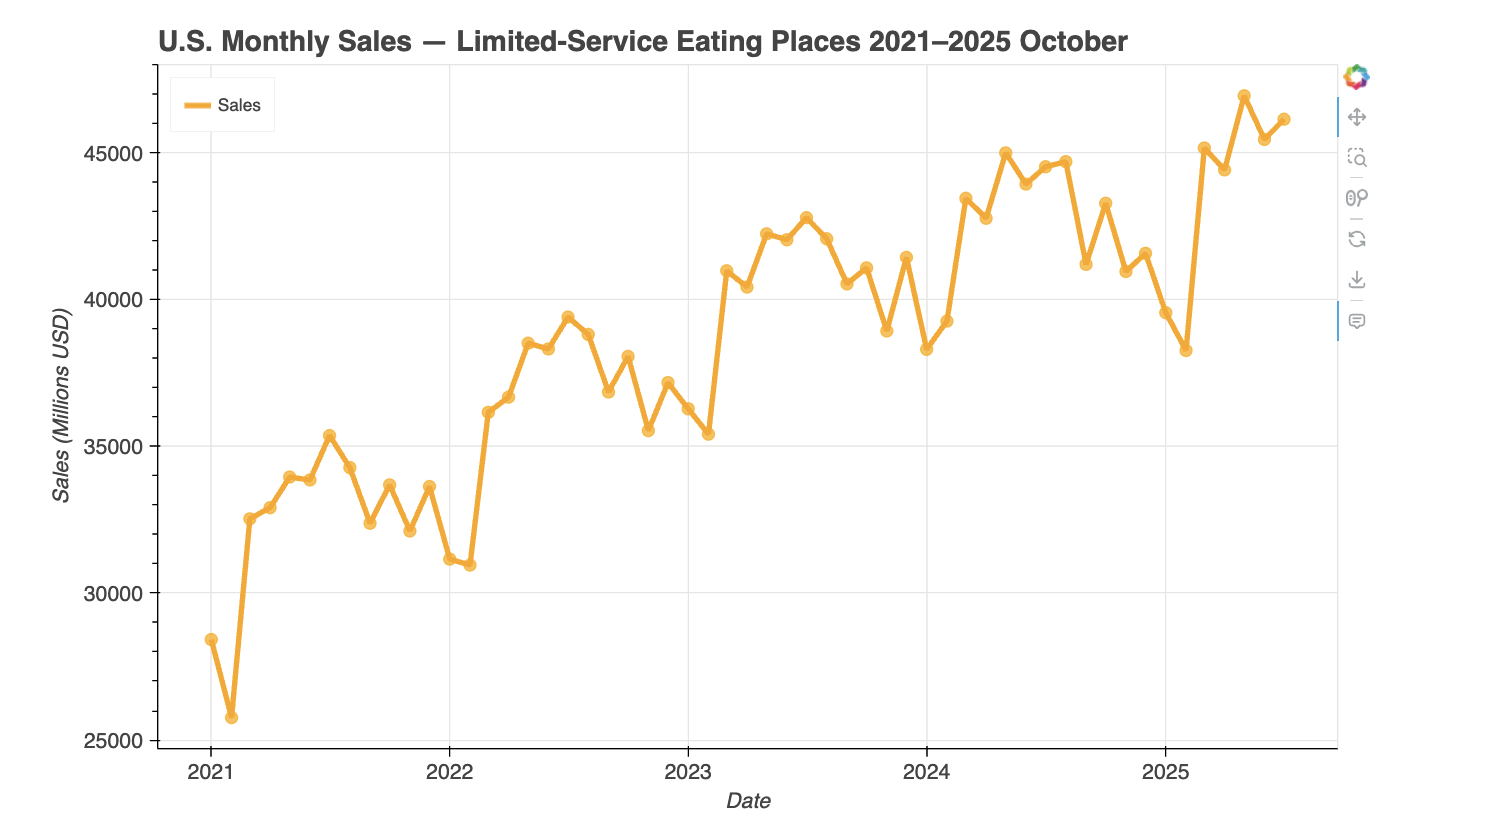

In [ ]:
# --- Define the FRED series ID for Food Services & Drinking Places ---
# This dataset (MRTSSM722USS) tracks monthly U.S. sales in millions of dollars
series_id = "MRTSSM722USS"

# --- Fetch monthly sales data from FRED ---
sales_df = fred.get_series(series_id).to_frame(name="sales_millions")

# Convert index to datetime for time-series analysis
sales_df.index = pd.to_datetime(sales_df.index)

# --- Filter data to include only years 2021–2024 ---
sales_df = sales_df[sales_df.index.year >= 2021]

# --- Aggregate monthly data into annual totals ---
sales_df_yearly = sales_df.resample("YE").sum()

# Replace DatetimeIndex with year values for cleaner display
sales_df_yearly.index = sales_df_yearly.index.year

# --- Drop incomplete data for 2025 ---
sales_df_yearly = sales_df_yearly[sales_df_yearly.index != 2025]

# --- Compute Year-over-Year (YoY) sales growth percentage ---
sales_df_yearly["yoy_growth_%"] = sales_df_yearly["sales_millions"].pct_change() * 100

# --- Display summary of annual sales and YoY growth ---
print("=== Annual Sales: Food Services & Drinking Places (Millions USD) ===")
print(sales_df_yearly.round(2), "\n")

# --- Prepare data for visualization (convert index to column for Bokeh) ---
source = ColumnDataSource(sales_df.reset_index().rename(columns={'index': 'Date'}))

# --- Create interactive Bokeh figure ---
sales_p = figure(
    title="U.S. Food Services & Drinking Places Sales (2021–2025 October)",
    x_axis_type="datetime",           # Interpret x-axis as time (dates)
    x_axis_label="Date",
    y_axis_label="Sales (Millions USD)",
    width=1000, height=600,
    tools="pan,wheel_zoom,box_zoom,reset,save")  # Enable interactive tools


# --- Plot line and scatter points for monthly sales ---
sales_p.line(
    'Date', 'sales_millions',
    source=source,
    line_width=4, color="green",
    legend_label="Sales")

sales_p.scatter(
    'Date', 'sales_millions',
    source=source,
    size=9, marker="circle",
    color="green", alpha=0.7)

# --- Add hover tool ---
hover = HoverTool(
    tooltips=[
        ("Date", "@Date{%Y-%m}"),               # Show formatted month/year
        ("Sales", "@sales_millions{0,0} M USD")],

    formatters={'@Date': 'datetime'},  # Format x-axis as datetime
    mode="vline")                      # Display hover info vertically

sales_p.add_tools(hover)

# --- Style and format plot appearance ---
sales_p.legend.location = "top_left"
sales_p.title.text_font_size = "16pt"
sales_p.xaxis.axis_label_text_font_size = "12pt"
sales_p.yaxis.axis_label_text_font_size = "12pt"
sales_p.xaxis.major_label_text_font_size = "12pt"
sales_p.yaxis.major_label_text_font_size = "12pt"

# --- Display the interactive chart ---
show(sales_p)


=== Annual Sales: Food Services & Drinking Places (Millions USD) ===
      sales_millions  yoy_growth_%
2021        823897.0           NaN
2022        956401.0         16.08
2023       1066809.0         11.54
2024       1118514.0          4.85 



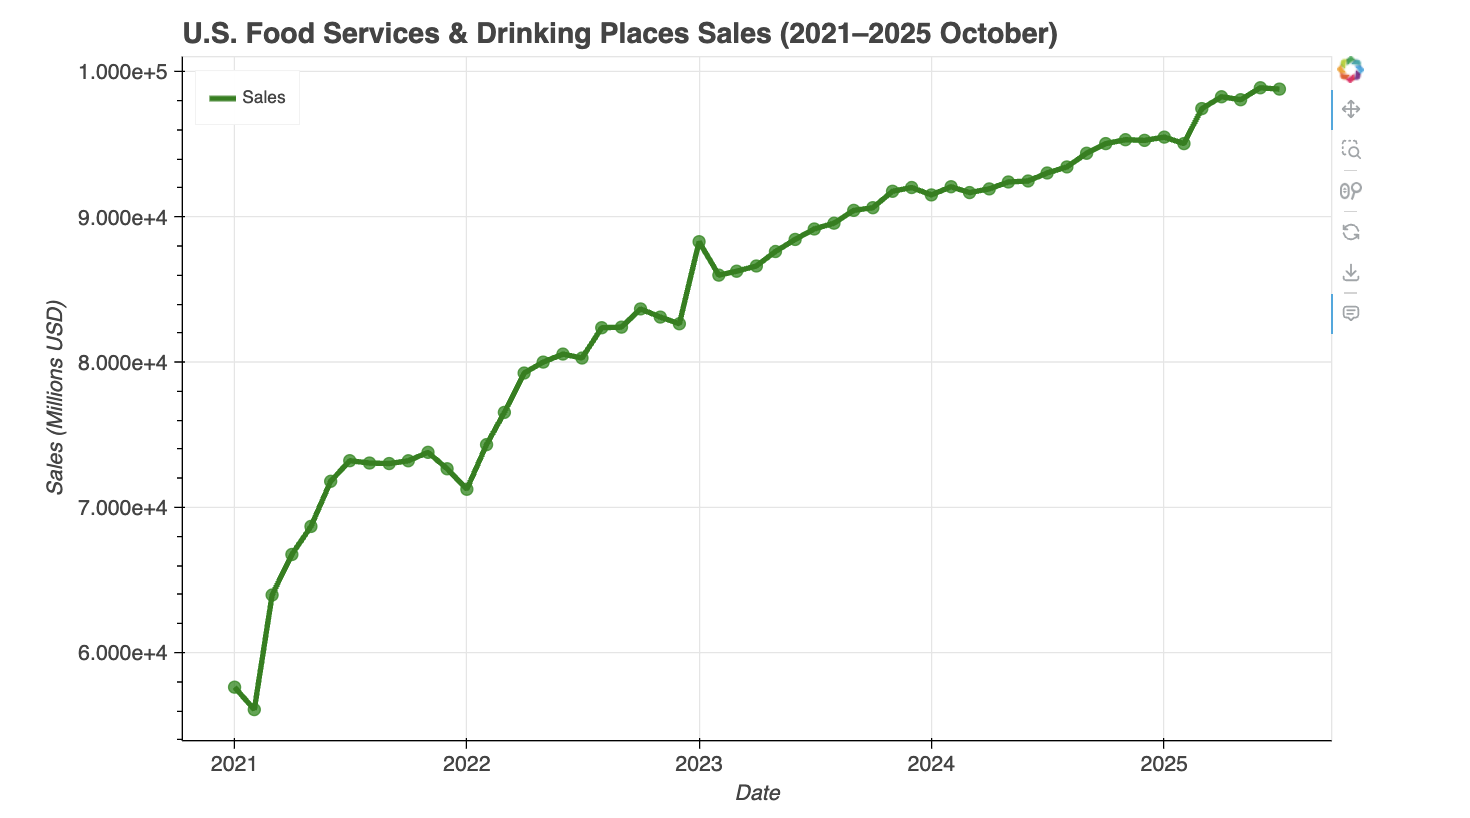

### 2.2 Consumer Interest — Google Trends Analysis

**Data Source:**

Google Trends, accessed via the pytrends library.

Data covers the past 5 years (2020–2025), focused on New York for brand-level analysis and U.S.-wide for keyword-level analysis.

1.Brand-Level:

Ten major fast casual chains were analyzed to evaluate relative consumer interest: Chipotle, Sweetgreen, Panera Bread, Just Salad, Playa Bowls, Dig Inn, CAVA, NAYA, QDOBA, Chopt

The Google Trends index (0–100) measures relative search frequency, averaged yearly to smooth weekly variations.

2.Keyword-Level:

Searched interest trends for broader health-oriented dining terms such as “healthy,” “salad,” “fresh,” “organic,” and “healthy food.”
Annual averages were computed to show long-term shifts in consumer mindset toward nutritious and wholesome eating.

**Interpretation:**

Brand Trends:

Major chains like Chipotle maintain the highest and most stable search interest, indicating strong brand recognition and sustained consumer engagement.

Emerging brands such as CAVA and NAYA show rising trends, suggesting growing market momentum and potential for regional expansion.

Overall, interest shows a growing trend across all brands, reinforcing steady demand for fast casual formats in New York.

Keyword Trends:

Keywords related to health and freshness (e.g., “healthy,” “salad,” “organic”) display consistent or rising search interest across the 2021–2025 period.

This reflects a cultural shift toward health-conscious dining, which is a key driver of the fast casual segment’s sustained growth.


In [ ]:
!pip install pytrends
from pytrends.request import TrendReq


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


       Chipotle  sweetgreen  Panera Bread  Just Salad  Playa Bowls   Dig Inn  \
year                                                                           
2020  66.090909    5.727273     28.636364    1.818182     1.272727  4.909091   
2021  70.596154    9.000000     27.096154    2.961538     2.596154  6.403846   
2022  62.865385   12.346154     19.538462    4.730769     3.153846  8.326923   
2023  62.150943   10.584906     16.547170    6.716981     4.169811  5.905660   
2024  71.346154   10.173077     13.192308    8.153846     4.865385  5.076923   
2025  71.285714    9.761905     11.571429    8.285714     5.023810  4.880952   

           CAVA       NAYA      QDOBA      Chopt  
year                                              
2020  14.909091  10.818182   8.818182  10.818182  
2021  18.230769   9.365385  10.000000  14.076923  
2022  25.480769  11.942308   8.980769  16.250000  
2023  35.886792  12.528302   8.754717  15.132075  
2024  46.576923  15.769231   9.923077  16.000000  
20

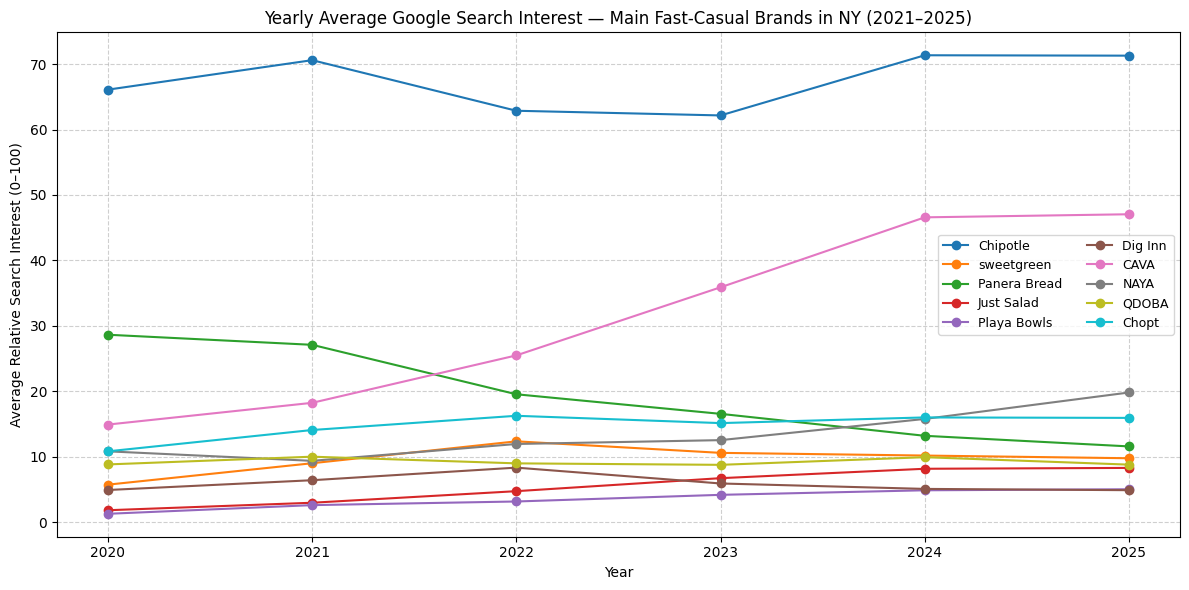

In [ ]:
# --- Initialize Pytrends connection ---
pytrends = TrendReq(hl='en-US', tz=-300)

# --- Define two groups of fast-casual restaurant brands (max 5 per request) ---
brands1 = ["Chipotle", "sweetgreen", "Panera Bread", "Just Salad", "Playa Bowls"]
brands2 = ["Dig Inn", "CAVA", "NAYA", "QDOBA", "Chopt"]

# --- Function: fetch and aggregate yearly Google Trends data ---
# timeframe='today 5-y' → last 5 years of weekly data
def get_yearly_trends(keywords, geo='US-NY', timeframe='today 5-y'):
    # Build search payload for given keywords, timeframe, and region
    pytrends.build_payload(keywords, timeframe=timeframe, geo=geo)

    # Get interest over time and drop incomplete weeks
    df = pytrends.interest_over_time().drop(columns=["isPartial"], errors='ignore')

    # Convert index to datetime and extract year
    df.index = pd.to_datetime(df.index)
    df['year'] = df.index.year

    # Group by year and compute yearly average interest
    return df.groupby('year').mean()

# --- Fetch yearly average interest for both groups ---
df1_yearly = get_yearly_trends(brands1)
df2_yearly = get_yearly_trends(brands2)

# --- Combine both groups into a single dataframe ---
df_all_yearly = pd.concat([df1_yearly, df2_yearly], axis=1)

# Drop duplicate columns and ensure numeric only
df_all_yearly = df_all_yearly.loc[:, ~df_all_yearly.columns.duplicated()]
df_all_yearly = df_all_yearly.select_dtypes(include='number')

# --- Display the yearly averaged search interest for brands---
print(df_all_yearly)

# --- Plot yearly search interest for all brands ---
plt.figure(figsize=(12,6))
for brand in df_all_yearly.columns:
    plt.plot(df_all_yearly.index, df_all_yearly[brand], marker='o', label=brand)

# --- Chart formatting and labels ---
plt.title("Yearly Average Google Search Interest — Main Fast-Casual Brands in NY (2021–2025)")
plt.xlabel("Year")
plt.ylabel("Average Relative Search Interest (0–100)")
plt.xticks(df_all_yearly.index)
plt.legend(ncol=2, fontsize=9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


        healthy      salad      fresh    organic  healthy food
year                                                          
2020  45.636364  41.181818  52.363636  19.000000      3.545455
2021  50.576923  51.288462  50.019231  20.000000      4.615385
2022  52.596154  56.634615  52.442308  21.519231      4.576923
2023  53.660377  56.943396  50.000000  22.396226      4.584906
2024  53.903846  56.480769  47.384615  24.269231      4.365385
2025  59.500000  58.976190  47.833333  26.904762      4.928571


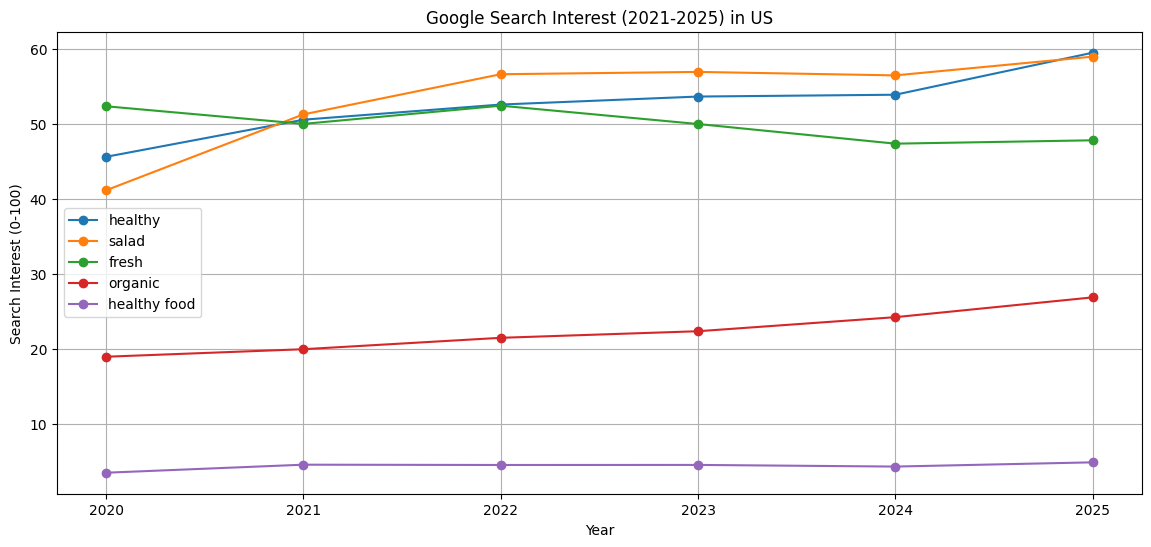

In [ ]:

# --- Define the keywords to track on Google Trends ---
kw_list = ["healthy", "salad", "fresh", "organic", "healthy food"]

# --- Build the payload for Pytrends ---
# timeframe='today 5-y' → last 5 years of weekly data
pytrends.build_payload(kw_list, timeframe='today 5-y', geo='US')

# --- Fetch interest over time data ---
df_trends2 = pytrends.interest_over_time()

# --- Drop the 'isPartial' column if it exists ---
df_trends2 = df_trends2.drop(columns=["isPartial"])

# --- Create a copy for yearly aggregation ---
df_trends2_yearly = df_trends2.copy()

# --- Ensure the index is datetime for proper time-based grouping ---
df_trends2_yearly.index = pd.to_datetime(df_trends2_yearly.index)

# --- Add a "year" column ---
df_trends2_yearly['year'] = df_trends2_yearly.index.year

# --- Group data by year and compute the average of weekly values ---
df_trends2_yearly = df_trends2_yearly.groupby('year').mean()

# --- Display the yearly averaged search interest ---
print(df_trends2_yearly)

# --- Plot trends for each keyword ---
plt.figure(figsize=(14,6))

for kw in kw_list:
    # Check that the keyword column exists in the DataFrame
    if kw in df_trends2_yearly.columns:
        # Plot yearly averages
        plt.plot(df_trends2_yearly.index, df_trends2_yearly[kw], marker='o', label=kw)

# --- Chart formatting and labels ---
plt.title("Google Search Interest (2021-2025) in US")
plt.xlabel("Year")
plt.ylabel("Search Interest (0-100)")
plt.legend()
plt.grid(True)
plt.show()


### 2.3 Price Dynamics — CPI Trends

**Data Source:**

FRED (Federal Reserve Economic Data)

CUSR0000SEFV: Consumer Price Index — Food Away from Home

CUSR0000SAF11: Consumer Price Index — Food at Home

These indicators measure how food prices have changed over time for dining out versus grocery purchases, offering insight into relative inflation pressures on restaurant customers.

**Interpretation:**

Food Away from Home (restaurants) shows a strong and persistent increase in prices from 2021 to 2024, reflecting higher labor, ingredient, and operating costs passed on to customers.

Food at Home (groceries) also increased, but at a slightly slower rate in certain years, narrowing or widening the dining-at-home vs dining-out cost gap.

The consistent rise in restaurant CPI suggests that inflationary pressure remains a challenge for operators, potentially moderating consumer frequency but not eliminating demand, as overall spending continues to rise (seen in section 2.1).

These dynamics highlight price elasticity considerations for the fast casual segment — where moderate price increases may be more acceptable to consumers seeking convenience and perceived quality.

In [ ]:
# --- Define FRED series for "Food Away from Home" CPI ---
series_id = "CUSR0000SEFV"

# --- Fetch monthly CPI data from FRED ---
cpi_df = fred.get_series(series_id)
cpi_df = cpi_df.to_frame(name="CPI_index")      # convert to DataFrame

# --- Convert index to datetime for time-series analysis ---
cpi_df.index = pd.to_datetime(cpi_df.index)

# --- Filter data for years 2021–2025 ---
cpi_df = cpi_df[cpi_df.index.year >= 2021]

# --- Compute annual average CPI ---
cpi_df_yearly = cpi_df.resample("YE").mean()     # resample to Year-End frequency and average
cpi_df_yearly.index = cpi_df_yearly.index.year   # replace index with just year numbers

# --- Drop incomplete year (2025) ---
cpi_df_yearly = cpi_df_yearly[cpi_df_yearly.index != 2025]

# --- Compute year-over-year growth (%) ---
cpi_df_yearly["yoy_growth_%"] = cpi_df_yearly["CPI_index"].pct_change() * 100

# --- Display annual CPI and YoY growth ---
print("=== Annual CPI: Food Away from Home ===")
print(cpi_df_yearly.round(2), "\n\n")

# --- Prepare data for interactive Bokeh plot ---
source = ColumnDataSource(
    cpi_df.reset_index().rename(columns={'index': 'Date'}))  # reset index and rename for Bokeh


# --- Create interactive figure ---
cpi_food_away_p = figure(
    title="CPI — Food Away from Home (2021–2025 October)",
    x_axis_type="datetime",          # interpret x-axis as dates
    x_axis_label="Date",
    y_axis_label="CPI Index Value",
    width=1000, height=600,
    tools="pan,wheel_zoom,box_zoom,reset,save")  # interactive tools

# --- Add line and scatter plots for monthly CPI values ---
cpi_food_away_p.line(
    'Date', 'CPI_index', source=source,
    line_width=4, color="firebrick",
    legend_label="CPI Index")

cpi_food_away_p.scatter(
    'Date', 'CPI_index', source=source,
    size=9, marker="circle", color="firebrick", alpha=0.7)

# --- Add hover tool to show exact date and CPI value ---
hover = HoverTool(
    tooltips=[
        ("Date", "@Date{%Y-%m}"),       # display year-month
        ("CPI Index", "@CPI_index{0.00}")],  # display CPI value with 2 decimals

    formatters={'@Date': 'datetime'},   # format x-axis as datetime
    mode="vline")                       # show tooltip on vertical line

cpi_food_away_p.add_tools(hover)

# --- Style and format plot appearance ---
cpi_food_away_p.legend.location = "top_left"
cpi_food_away_p.title.text_font_size = "16pt"
cpi_food_away_p.xaxis.axis_label_text_font_size = "12pt"
cpi_food_away_p.yaxis.axis_label_text_font_size = "12pt"
cpi_food_away_p.xaxis.major_label_text_font_size = "12pt"
cpi_food_away_p.yaxis.major_label_text_font_size = "12pt"

# --- Display the interactive plot ---
show(cpi_food_away_p)

=== Annual CPI: Food Away from Home ===
      CPI_index  yoy_growth_%
2021     307.30           NaN
2022     330.82          7.66
2023     354.26          7.08
2024     368.74          4.09 




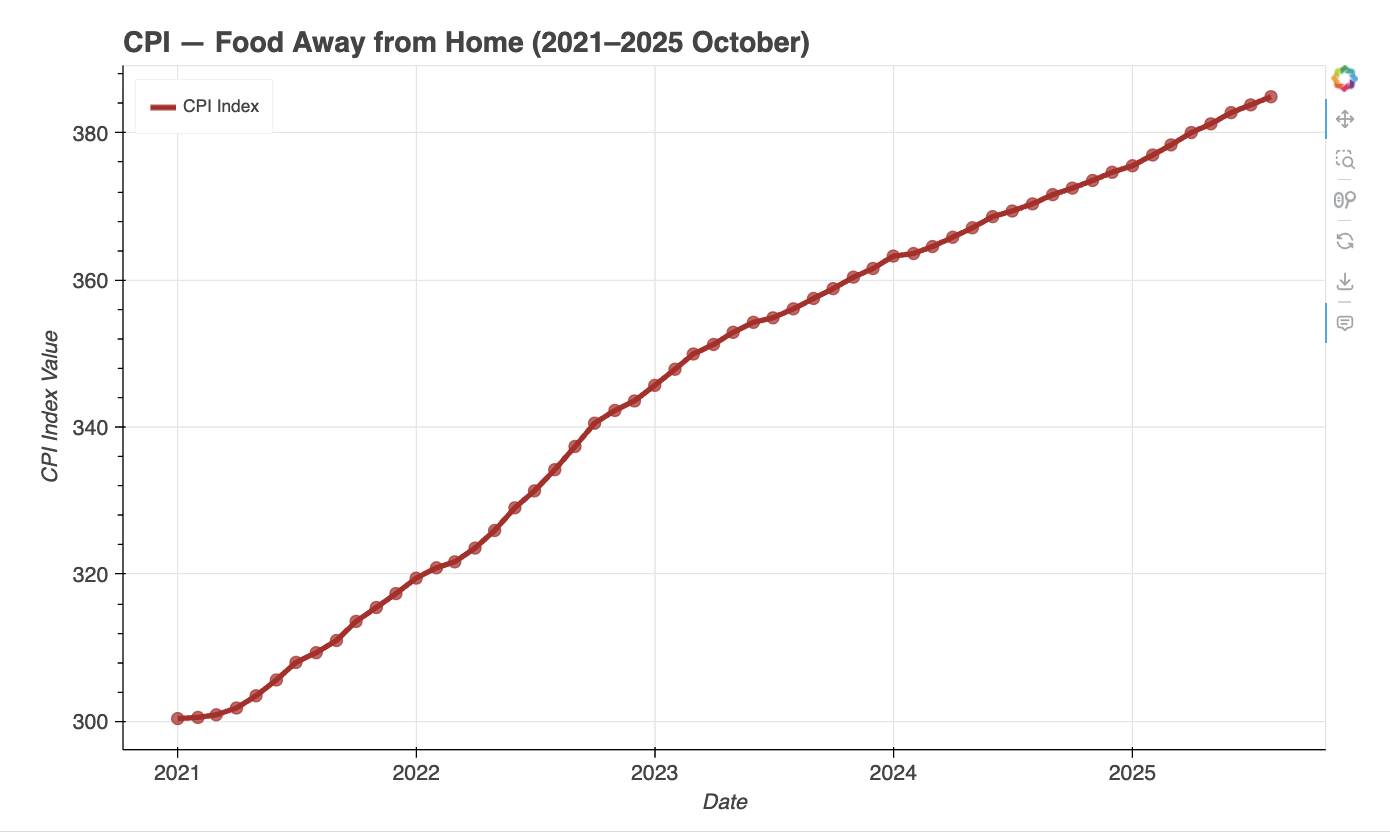

In [ ]:
# --- Define FRED series for "Food at Home" CPI ---
series_id_home = "CUSR0000SAF11"

# --- Fetch monthly CPI data and convert to DataFrame ---
cpi_home_df = fred.get_series(series_id_home).to_frame(name="CPI_index")

# --- Convert index to datetime for time-series analysis ---
cpi_home_df.index = pd.to_datetime(cpi_home_df.index)

# --- Filter data for years 2021–2025 ---
cpi_home_df = cpi_home_df[cpi_home_df.index.year >= 2021]

# --- Compute annual average CPI (mean of 12 months) ---
cpi_home_yearly = cpi_home_df.resample("YE").mean()  # resample to Year-End frequency
cpi_home_yearly.index = cpi_home_yearly.index.year   # use just year numbers as index

# --- Drop incomplete year (2025) ---
cpi_home_yearly = cpi_home_yearly[cpi_home_yearly.index != 2025]

# --- Compute year-over-year growth (%) ---
cpi_home_yearly["yoy_growth_%"] = cpi_home_yearly["CPI_index"].pct_change() * 100

# --- Display annual CPI and YoY growth ---
print("\n=== Annual CPI: Food at Home ===")
print(cpi_home_yearly.round(2), "\n\n")

# --- Prepare data for interactive Bokeh plot ---
source = ColumnDataSource(
    cpi_home_df.reset_index().rename(columns={'index': 'Date'}))  # reset index and rename for Bokeh

# --- Create interactive figure ---
cpi_food_at_home_p = figure(
    title="CPI — Food at Home (2021–2025 October)",
    x_axis_type="datetime",          # interpret x-axis as dates
    x_axis_label="Date",
    y_axis_label="CPI Index Value",
    width=1000, height=600,
    tools="pan,wheel_zoom,box_zoom,reset,save")  # interactive tools

# --- Add line and scatter plots for monthly CPI values ---
cpi_food_at_home_p.line(
    'Date', 'CPI_index', source=source,
    line_width=4, color="royalblue",
    legend_label="CPI Index")

cpi_food_at_home_p.scatter(
    'Date', 'CPI_index', source=source,
    size=9, marker="circle", color="royalblue", alpha=0.7)

# --- Add hover tool to show exact date and CPI value ---
hover = HoverTool(
    tooltips=[
        ("Date", "@Date{%Y-%m}"),       # display year-month
        ("CPI Index", "@CPI_index{0.00}")],  # display CPI value with 2 decimals

    formatters={'@Date': 'datetime'},   # format x-axis as datetime
    mode="vline")                       # show tooltip on vertical line

cpi_food_at_home_p.add_tools(hover)

# --- Style and format plot appearance ---
cpi_food_at_home_p.legend.location = "top_left"
cpi_food_at_home_p.title.text_font_size = "16pt"
cpi_food_at_home_p.xaxis.axis_label_text_font_size = "12pt"
cpi_food_at_home_p.yaxis.axis_label_text_font_size = "12pt"
cpi_food_at_home_p.xaxis.major_label_text_font_size = "12pt"
cpi_food_at_home_p.yaxis.major_label_text_font_size = "12pt"

# --- Display the interactive plot ---
show(cpi_food_at_home_p)



=== Annual CPI: Food at Home ===
      CPI_index  yoy_growth_%
2021     258.88           NaN
2022     288.46         11.42
2023     302.91          5.01
2024     306.54          1.20 




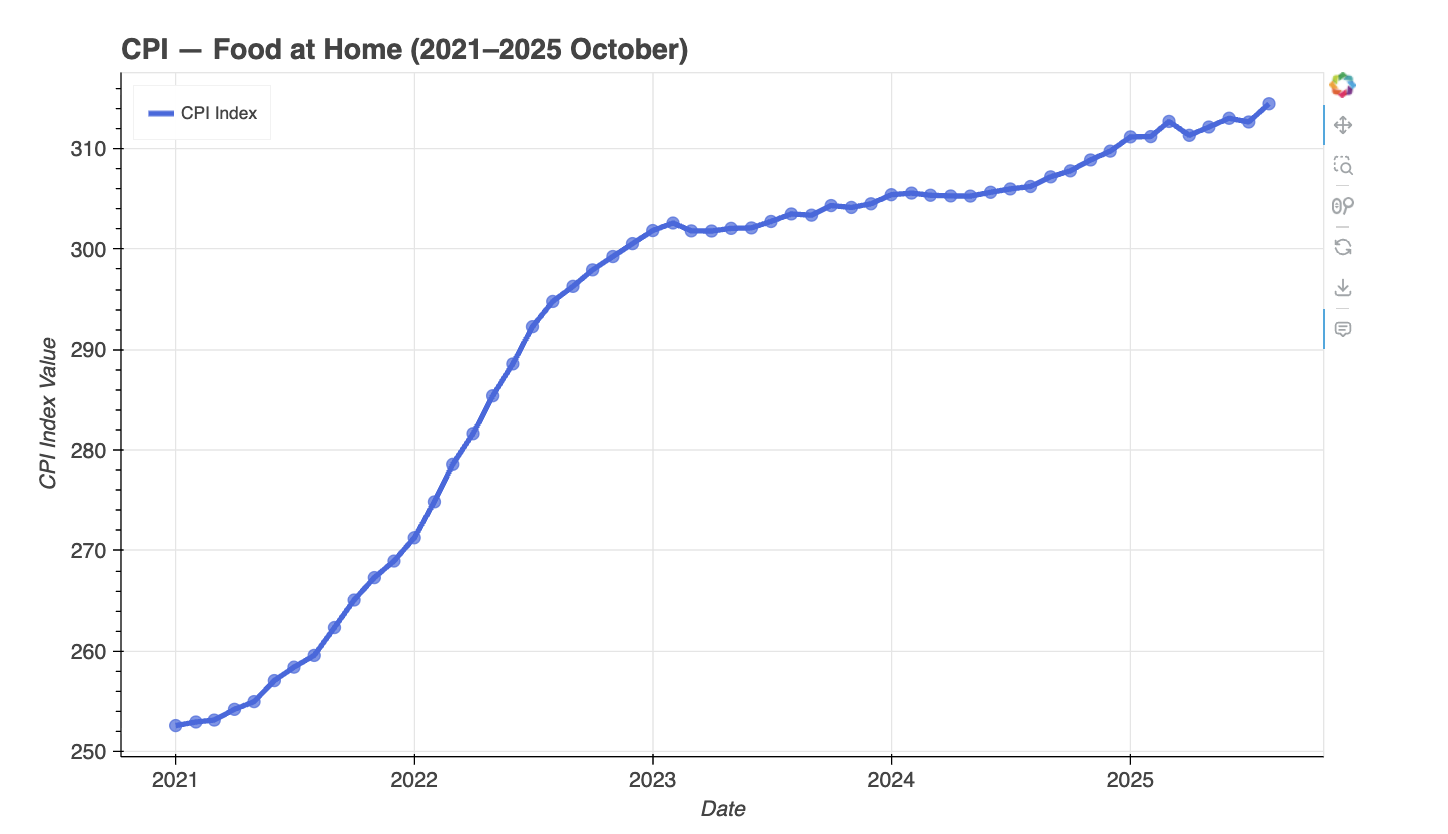

### 2.4 Summary Insight

By combining sales growth, consumer interest, and price inflation, this analysis provides a comprehensive view of demand trends:

Demand remains strong, with both sales and search interest increasing.

Consumer values continue to shift toward health, freshness, and convenience.

Inflationary pressures affect pricing, but fast casual dining maintains resilience due to its balance of value and quality.

Together, these indicators portray a growing yet maybe mild price-sensitive market.

## **3.Rivalry and Profitability Analysis**

**Purpose:**

To evaluate both the competitive intensity within New York’s fast casual restaurant market and the profitability performance of major industry players. This dual analysis helps reveal where competition is most concentrated geographically and the financial performance of major fast_casual chains.


### 3.1 Market Competition:
**Data Source:**

Yelp Developers - combined_fast_casual

**Logic:**

City-Level Competition: Count the number of fast-casual restaurants per city in New York to reveal where competition is most concentrated.

Spatial Density: Use an interactive density heatmap to visualize restaurant clustering in New York.

Ranking: Sort and plot the top cities by store count to identify the most saturated markets.

**Interpretation:**

The high concentration of fast-casual locations in New York City indicates intense market rivalry, with significant clustering in Manhattan and Brooklyn. Such spatial density suggests saturated local markets and high competitive pressure for differentiation and customer loyalty. However, as we move outward to less urban areas, the density and competition levels drop significantly.

In [ ]:
# Count total number of fast casual restaurants for each city in NY
city_counts = combined_fast_casual.groupby('city').size().reset_index(name='store_count')

# Sort by number (high to low)
city_counts = city_counts.sort_values('store_count', ascending=False)

# Display the result
print(city_counts)

                   city  store_count
22             New York          224
3              Brooklyn           35
2                 Bronx            7
9           Garden City            3
31        Staten Island            3
25            Oceanside            2
1               Bayside            2
0               Astoria            2
8         Fresh Meadows            2
17     Long Island City            2
26               Queens            2
7              Elmhurst            2
15              Jamaica            2
30            Scarsdale            2
29            Rye Brook            2
33             Westbury            2
4                  City            1
12           Great Neck            1
10            Glen Cove            1
5           Dobbs Ferry            1
6         East Elmhurst            1
20        New Hyde Park            1
19           Massapequa            1
18           Mamaroneck            1
16             Lawrence            1
13             Islandia            1
1

In [ ]:
import folium
from folium.plugins import HeatMap

# --- Create a density heatmap for fast-casual restaurants in NY ---
map = folium.Map(location=combined_fast_casual[['latitude', 'longitude']].values[0])
HeatMap(combined_fast_casual[['latitude', 'longitude']].values, blur = 1, radius = 5).add_to(map);
map


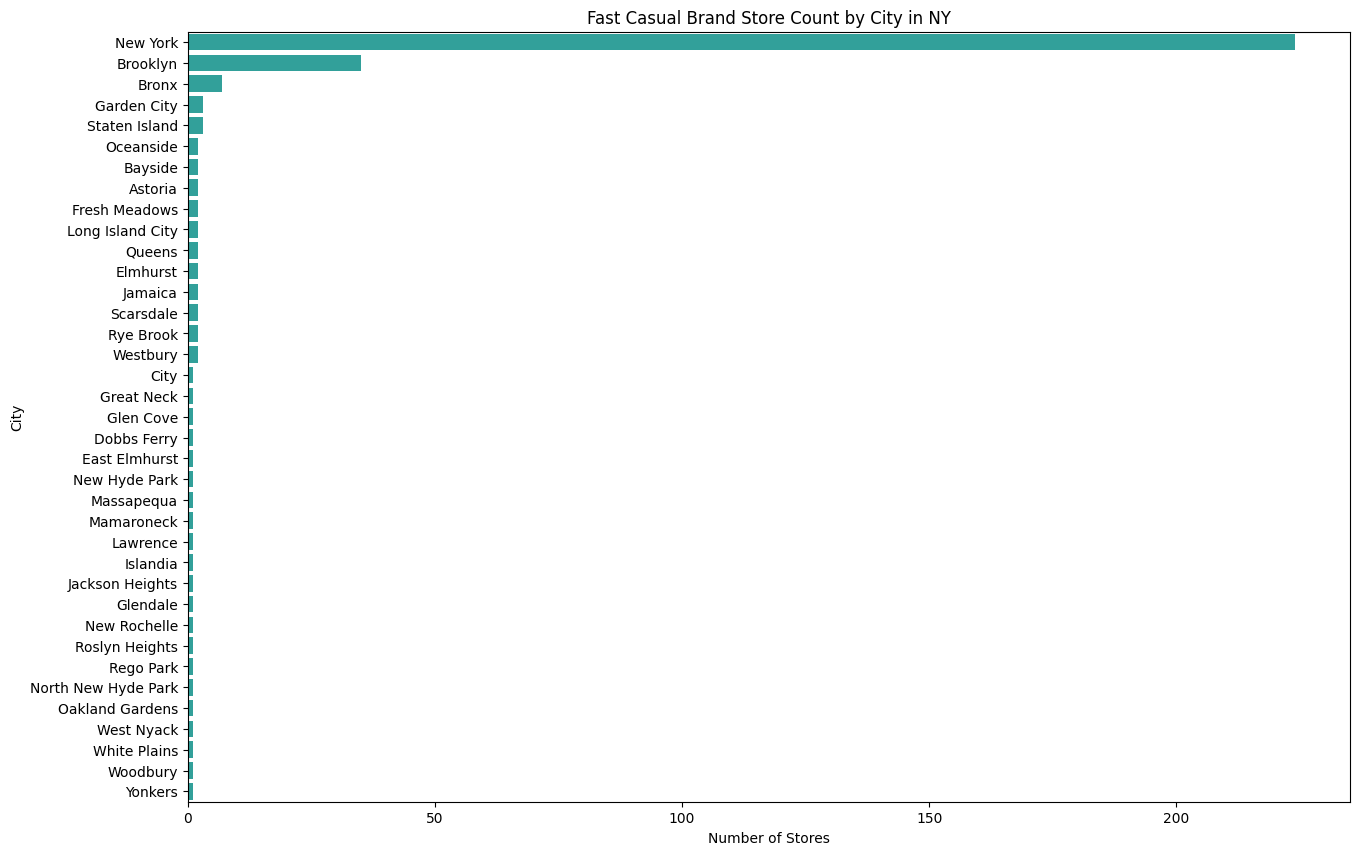

In [ ]:
# --- Barplot showing number of fast-casual restaurants per city ---
plt.figure(figsize=(15,10))
sns.barplot(x='store_count', y='city', data=city_counts, color = 'lightseagreen')
plt.title("Fast Casual Brand Store Count by City in NY")
plt.xlabel("Number of Stores")
plt.ylabel("City")
plt.show()

## 3.2 Zip code ranking
**Purpose:**

Identify which zip codes in New York appear most promising for opening a new healthy fast-casual location by integrating three local signals:

how many competitors already exist (density), how well-rated they are (customer satisfaction), and how many reviews they attract (foot traffic proxy).

**Logic:**

To rank New York zip codes by entry potential, I calculate a composite "Opportunity Score" that balances demand, satisfaction, and competition, then normalized the score for comparability.

Score = 0.5*(reviews) + 0.4*(ratings) + 0.1*(1-competitors)

Interpretation of the formula:

reviews_s (weight = 0.5):
Reviews are used as a proxy for local market activity and visibility.
A high review count means the area attracts strong customer attention and foot traffic — hence the largest weight (50%).

rating_s (weight = 0.4):
Ratings capture customer satisfaction and the maturity of local demand.
High-rated competitors imply that customers in the area value quality and are willing to spend on healthy fast-casual options.
However, since satisfaction doesn’t necessarily equal volume, it gets a slightly smaller weight (40%).

(1 - competitors_s) (weight = 0.1):
Competitor density measures market saturation.
The subtraction (1 - competitors_s) inverts the scale so that fewer competitors → higher opportunity. The low weight (10%) reflects the idea that competition matters but does not entirely determine potential — a crowded market can still be profitable if demand is high.

In general, Higher oppurtinity scores indicate zip codes with strong engagement, satisfied customers, and manageable competition, which can be ideal targets for new healthy fast-casual entries.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# --- Aggregate metrics by zip code ---
z = combined_fast_casual.groupby('zip_code').agg(
    competitors=('name','count'),
    avg_rating=('rating','mean'),
    total_reviews=('review_count','sum')).reset_index()

# --- Normalize for comparability ---
scaler = MinMaxScaler()
z[['competitors_s','reviews_s','rating_s']] = scaler.fit_transform(
    z[['competitors','total_reviews','avg_rating']].fillna(0))

# --- Compute opportunity score ---
z['score'] = z['reviews_s']*0.5 + z['rating_s']*0.4 + (1 - z['competitors_s'])*0.1

# --- Sort descending: top zip codes = best trade areas ---
z = z.sort_values('score', ascending=False)

# --- Display the result ---
display(z.head(20))


,zip_code,competitors,avg_rating,total_reviews,competitors_s,reviews_s,rating_s,score
2,10003,16,3.418750,3734,0.75,1.000000,0.683750,0.798500
0,10001,21,3.719048,2608,1.00,0.698447,0.743810,0.646747
11,10013,4,3.600000,1868,0.15,0.500268,0.720000,0.623134
8,10010,12,3.650000,2134,0.55,0.571505,0.730000,0.622753
24,10028,6,3.266667,2127,0.25,0.569630,0.653333,0.621149
10,10012,9,3.888889,1711,0.40,0.458222,0.777778,0.600222
16,10019,15,3.466667,2128,0.70,0.569898,0.693333,0.592282
19,10022,15,3.526667,2054,0.70,0.550080,0.705333,0.587174
69,11238,2,4.700000,812,0.05,0.217461,0.940000,0.579731
66,11222,3,4.100000,1180,0.10,0.316015,0.820000,0.576007


### 3.3 Profitability Analysis:
**Data Source:**

Yahoo Finance - final_df

**Logic:**

Use financial statements from key publicly traded fast-casual chains — Chipotle Mexican Grill (CMG), Sweetgreen (SG), and CAVA Group Inc. (CAVA) — as representative benchmarks. Assess overall industry profitability by analyzing trends in revenue, cost efficiency, and returns on assets.

Focus on both growth and efficiency indicators:

Revenue — overall scale and expansion

Gross Margin — efficiency in production and sourcing

Operating Margin — cost control and scalability

Profit Margin — overall profitability

ROA (Return on Assets) — capital efficiency

**Interpretation:**

Across 2021–2024, the fast-casual industry shows mixed profitability:

Chipotle sets the industry benchmark with consistent revenue growth and robust double-digit margins, supported by strong brand equity and efficient digital operations.

CAVA and Sweetgreen illustrate the typical growth-to-profitability tradeoff in this sector — rapid expansion and high labor/ingredient costs keep margins thin or negative.

Gross Margins (20–40%) indicate healthy unit-level economics, but Operating Margins (−10% to 15%) reveal pressure from inflation, real estate costs, and marketing competition.

Profit margins and ROA are keep increasing, but the big difference among companies signals that profitability is concentrated among scale leaders rather than evenly distributed.

The pattern suggests that while the fast-casual market remains high-growth, it is also low-margin and capital-intensive.



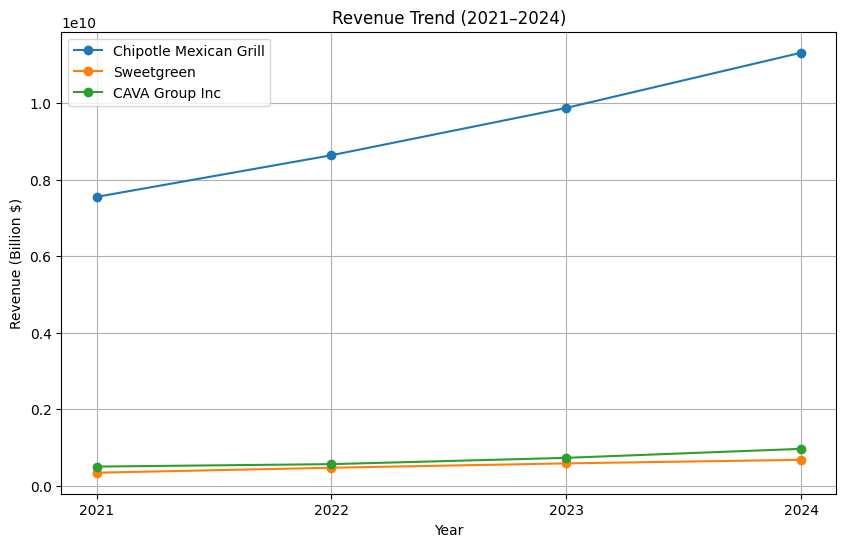

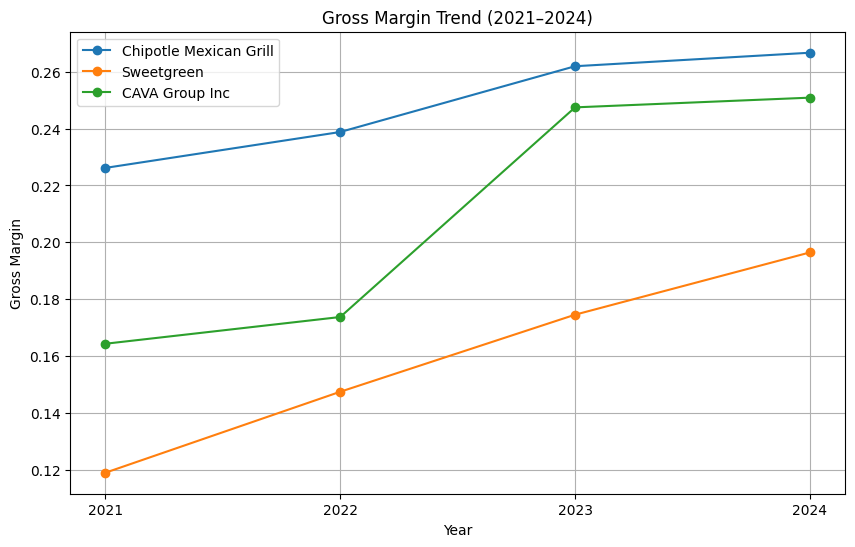

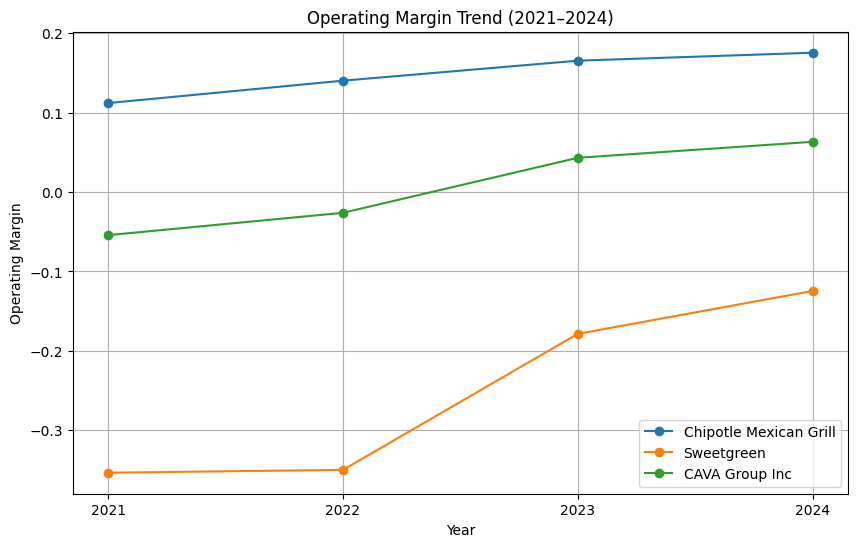

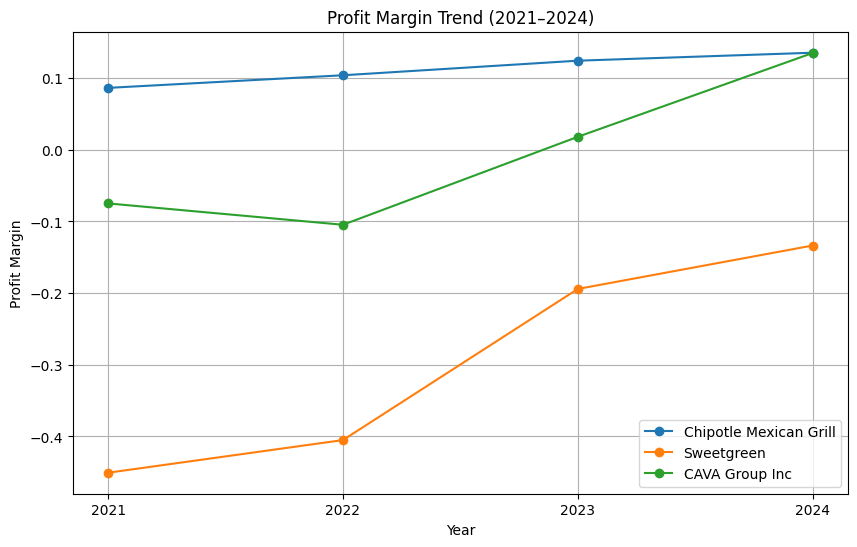

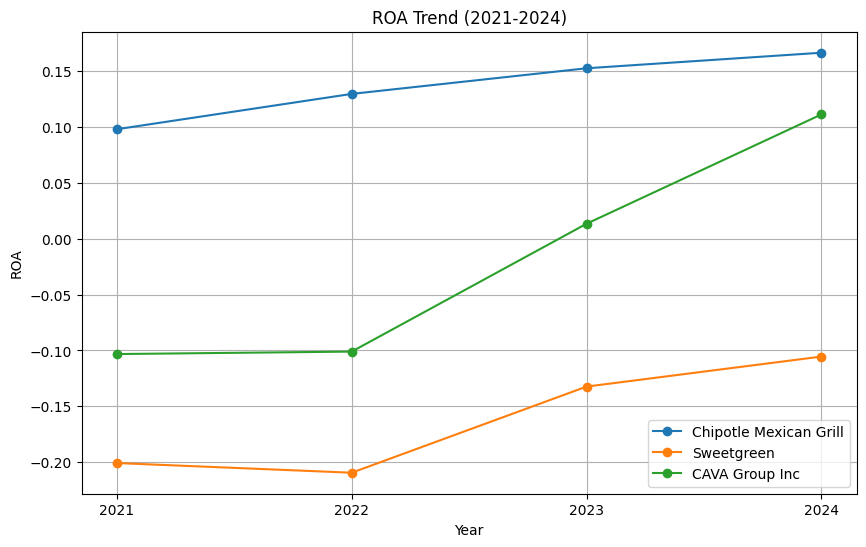

,Revenue,Gross_Profit,Operating_Income,Net_Income,Total_Assets,Gross_Margin,Operating_Margin,Profit_Margin,ROA,Company,Year
0,1.131385e+10,3.017692e+09,1.985179e+09,1.534110e+09,9.204374e+09,0.266725,0.175464,0.135596,0.166672,Chipotle Mexican Grill,2024
1,9.871649e+09,2.586092e+09,1.633114e+09,1.228737e+09,8.044362e+09,0.261972,0.165435,0.124471,0.152745,Chipotle Mexican Grill,2023
2,8.634652e+09,2.062119e+09,1.211102e+09,8.991010e+08,6.927504e+09,0.238819,0.140261,0.104127,0.129787,Chipotle Mexican Grill,2022
3,7.547061e+09,1.707009e+09,8.454980e+08,6.529840e+08,6.652958e+09,0.226182,0.112030,0.086522,0.098149,Chipotle Mexican Grill,2021
5,6.768260e+08,1.329490e+08,-8.433900e+07,-9.037300e+07,8.567580e+08,0.196430,-0.124610,-0.133525,-0.105483,Sweetgreen,2024
6,5.840410e+08,1.019200e+08,-1.043330e+08,-1.133840e+08,8.565570e+08,0.174508,-0.178640,-0.194137,-0.132372,Sweetgreen,2023
7,4.701050e+08,6.928600e+07,-1.645520e+08,-1.904410e+08,9.089350e+08,0.147384,-0.350032,-0.405103,-0.209521,Sweetgreen,2022
8,3.398740e+08,4.040500e+07,-1.201840e+08,-1.531750e+08,7.626490e+08,0.118882,-0.353613,-0.450682,-0.200846,Sweetgreen,2021
10,9.637130e+08,2.418050e+08,6.095000e+07,1.303190e+08,1.169669e+09,0.250910,0.063245,0.135226,0.111415,CAVA Group Inc,2024
11,7.287000e+08,1.803460e+08,3.142200e+07,1.328000e+07,9.837570e+08,0.247490,0.043121,0.018224,0.013499,CAVA Group Inc,2023


In [ ]:

# --- Define stock tickers and corresponding company names ---
companies = {
    'CMG': 'Chipotle Mexican Grill',
    'SG': 'Sweetgreen',
    'CAVA': 'CAVA Group Inc'}

# --- Initialize list to store processed data for all companies ---
all_data = []

# --- Loop through each company to extract and process financials ---
for ticker, name in companies.items():
    stock = yf.Ticker(ticker)  # create yfinance Ticker object

    # --- Extract financial statements ---
    fin = stock.financials.T           # income statement (transpose for dates as rows)
    bs = stock.balance_sheet.T         # balance sheet (transpose for dates as rows)

    # --- Ensure both DataFrames have datetime index ---
    fin.index = pd.to_datetime(fin.index)
    bs.index = pd.to_datetime(bs.index)

    # --- Merge total assets from balance sheet into income statement ---
    fin = fin.join(bs[['Total Assets']], how='left')

    # --- Keep relevant columns and rename ---
    fin = fin[['Total Revenue', 'Gross Profit', 'Operating Income', 'Net Income', 'Total Assets']]
    fin.columns = ['Revenue', 'Gross_Profit', 'Operating_Income', 'Net_Income', 'Total_Assets']

    # --- Compute key financial ratios/margins ---
    fin['Gross_Margin'] = fin['Gross_Profit'] / fin['Revenue']          # Gross profit margin
    fin['Operating_Margin'] = fin['Operating_Income'] / fin['Revenue']  # Operating margin
    fin['Profit_Margin'] = fin['Net_Income'] / fin['Revenue']           # Net profit margin
    fin['ROA'] = fin['Net_Income'] / fin['Total_Assets']                # Return on assets

    # --- Add identifying columns ---
    fin['Company'] = name
    fin['Year'] = fin.index.year  # extract year from index

    # --- Append processed company data to list ---
    all_data.append(fin.reset_index(drop=True))

# --- Combine all companies into a single DataFrame ---
final_df = pd.concat(all_data, ignore_index=True).dropna()  # remove any missing data

# --- Function to plot trend for any financial metric ---
def plot_trend(df, value_col, title, ylabel):
    plt.figure(figsize=(10,6))
    for company in df['Company'].unique():  # loop through each company
        df_plot = df[df['Company'] == company]  # filter data for this company
        plt.plot(df_plot['Year'], df_plot[value_col], marker='o', label=company)
    plt.xticks(sorted(df['Year'].unique()))
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Plot financial trends for all companies ---
plot_trend(final_df, 'Revenue', 'Revenue Trend (2021–2024)', 'Revenue (Billion $)')
plot_trend(final_df, 'Gross_Margin', 'Gross Margin Trend (2021–2024)', 'Gross Margin')
plot_trend(final_df, 'Operating_Margin', 'Operating Margin Trend (2021–2024)', 'Operating Margin')
plot_trend(final_df, 'Profit_Margin', 'Profit Margin Trend (2021–2024)', 'Profit Margin')
plot_trend(final_df,'ROA','ROA Trend (2021-2024)','ROA')

# --- Show final processed DataFrame ---
final_df


### 3.4 Summary Insights
The fast-casual dining industry demonstrates strong demand but limited profitability for most players. Rivalry is intense, especially in urban centers like NYC, where oversaturation limits pricing power. Profitability is polarized — dominant brands such as Chipotle achieve efficiency-driven margins, while smaller or emerging chains struggle amid high costs and fierce competition. Overall, the industry operates in a high-rivalry, moderate-profitability equilibrium, where differentiation and scale are the keys.

## **4.Threat of Substitution**
**Purpose:**

This section evaluates the threat of substitution in the fast-casual restaurant industry — specifically, how changes in relative food prices and consumer search behavior reflect shifts between dining out and eating at home. Substitution pressure affects buyer retention and price flexibility: when home-cooked or delivery options become cheaper or more appealing, restaurant demand weakens.

Data Sources

Consumer Price Index (CPI) data from the Federal Reserve Economic Data (FRED) API:

CUSR0000SEFV — Food Away from Home (restaurant meals)

CUSR0000SAF11 — Food at Home (groceries and meal ingredients)

Google Trends data (via pytrends):

Keyword groups representing substitutes such as meal kits, grocery delivery, and home cooking

**Logic:**

Relative Price Analysis:

Calculated annual CPI growth rates for Food Away from Home and Food at Home (2021–2024).

Computed the Substitution Pressure Index (SPI) = (Food-at-Home YoY Inflation / Food-Away-from-Home YoY Inflation).

SPI < 1 → Home food prices rising slower → Eating at home becomes cheaper → Higher substitution threat.

SPI > 1 → Home food prices rising faster → Eating out more cost-competitive → Lower substitution threat.

Consumer Interest Analysis:

Collected Google Trends data for various substitute categories (e.g., meal kits, home cooking, grocery delivery) and compared normalized search interest (0–100) to healthy fast-casual restaurants.

Averaged keyword trends to assess long-term popularity shifts between substitutes and fast-casual concepts.

**Interpretation:**

The Substitution Pressure Index (SPI) declined below 1 in 2024, suggesting that eating at home became relatively cheaper compared to dining out. This implies a potential rising threat from at-home alternatives, particularly among price-sensitive consumers.

However, Google Trends data presents a complementary and somewhat contrasting picture: search interest for “healthy fast casual” continues to rise steadily and remains significantly higher than for substitutes such as meal kits, grocery delivery, and home cooking, which have shown declining interest since 2023. This indicates that, despite relative price pressures, consumer preference strongly favors healthy fast-casual options over at-home alternatives.

In conclusion, the threat of substitution is moderate. Healthy fast-casual restaurants remain the preferred choice for urban, health-conscious consumers. Success depends on maintaining strong brand identity, menu innovation, and convenience-focused service, rather than competing solely on price.

=== Substitution Pressure Index (SPI) ===
      Food_Away_CPI  Food_Home_CPI  Away_YoY_%  Home_YoY_%   SPI
2021         307.30         258.88         NaN         NaN   NaN
2022         330.82         288.46        7.66       11.42  1.49
2023         354.26         302.91        7.08        5.01  0.71
2024         368.74         306.54        4.09        1.20  0.29 




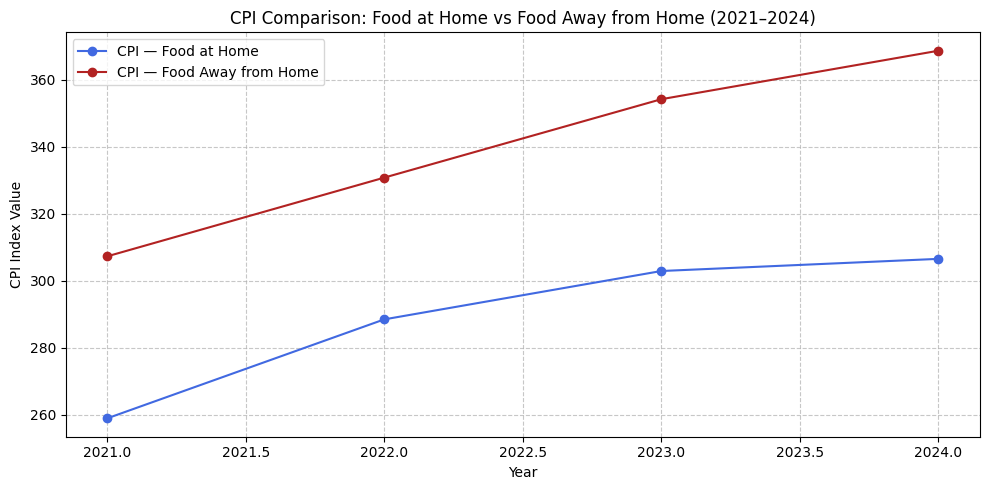

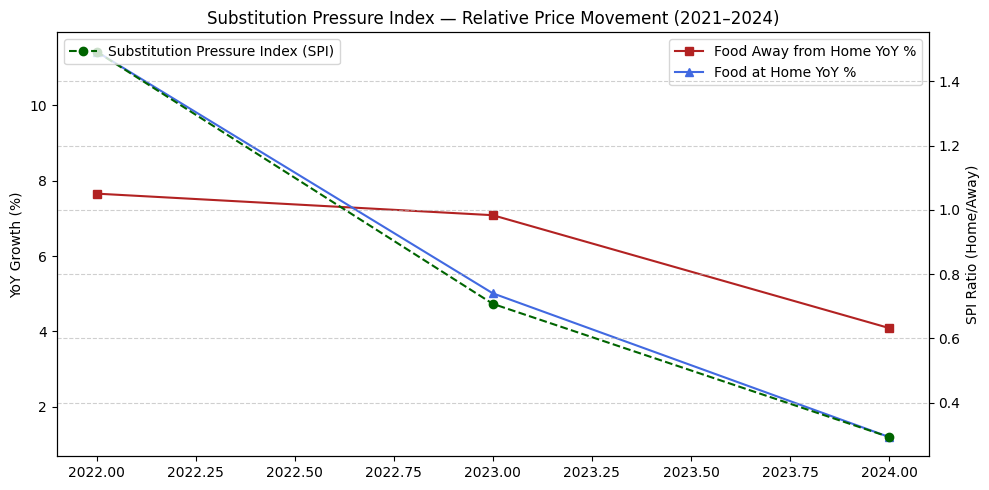



Substitution threat rising — eating at home is becoming relatively cheaper (SPI = 0.29).


In [ ]:
# --- Combine the two CPI datasets into one DataFrame ---
sub_df = pd.DataFrame({
    'Food_Away_CPI': cpi_df_yearly['CPI_index'],
    'Food_Home_CPI': cpi_home_yearly['CPI_index']})

# --- Compute Year-over-Year (YoY) growth rates for each CPI series ---
sub_df['Away_YoY_%'] = sub_df['Food_Away_CPI'].pct_change() * 100
sub_df['Home_YoY_%'] = sub_df['Food_Home_CPI'].pct_change() * 100

# --- Compute Substitution Pressure Index (SPI) ---
# SPI = (Food-at-home inflation rate / Food-away-from-home inflation rate)
#   SPI > 1 → home food prices rising faster → less substitution threat
#   SPI < 1 → eating at home relatively cheaper → higher substitution threat
sub_df['SPI'] = sub_df['Home_YoY_%'] / sub_df['Away_YoY_%']

# --- Display the SPI table ---
print("=== Substitution Pressure Index (SPI) ===")
print(sub_df.round(2), "\n\n")

# --- Plot CPI Comparison: Food at Home vs Food Away from Home ---
plt.figure(figsize=(10,5))
plt.plot(sub_df.index, sub_df['Food_Home_CPI'], marker='o', label='CPI — Food at Home', color='royalblue')
plt.plot(sub_df.index, sub_df['Food_Away_CPI'], marker='o', label='CPI — Food Away from Home', color='firebrick')
plt.title("CPI Comparison: Food at Home vs Food Away from Home (2021–2024)")
plt.xlabel("Year")
plt.ylabel("CPI Index Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot YoY Growth & SPI on dual axes ---
fig, ax1 = plt.subplots(figsize=(10,5))

# Left axis: YoY growth percentages
ax1.plot(sub_df.index, sub_df['Away_YoY_%'], marker='s', label='Food Away from Home YoY %', color='firebrick')
ax1.plot(sub_df.index, sub_df['Home_YoY_%'], marker='^', label='Food at Home YoY %', color='royalblue')
ax1.set_ylabel("YoY Growth (%)")
ax1.legend(loc='upper right')

# Right axis: SPI ratio
ax2 = ax1.twinx()
ax2.plot(sub_df.index, sub_df['SPI'], color='darkgreen', linestyle='--', marker='o', label='Substitution Pressure Index (SPI)')
ax2.set_ylabel("SPI Ratio (Home/Away)")
ax2.legend(loc='upper left')

plt.title("Substitution Pressure Index — Relative Price Movement (2021–2024)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print("\n")

# --- Interpretation of latest SPI value ---
latest_spi = sub_df['SPI'].iloc[-1]
if latest_spi < 1:
    print(f"Substitution threat rising — eating at home is becoming relatively cheaper (SPI = {latest_spi:.2f}).")
elif latest_spi > 1:
    print(f"Substitution threat easing — restaurant meals are becoming relatively more cost-competitive (SPI = {latest_spi:.2f}).")
else:
    print(f"Substitution pressure stable — no major shift detected (SPI = {latest_spi:.2f}).")



/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('fut

            Healthy fast-casual  Meal kits  Grocery delivery  Home cooking
date                                                                      
2020-10-18             5.050505  30.208333         30.985915     33.333333
2020-10-25             5.050505  31.250000         28.169014     27.192982
2020-11-01             4.040404  15.625000         12.676056     13.157895
2020-11-08             4.040404  28.125000         29.577465     24.561404
2020-11-15             4.040404  32.291667         54.929577     23.684211
...                         ...        ...               ...           ...
2025-09-21            70.707071  13.541667         21.126761     29.824561
2025-09-28            68.686869   9.375000         18.309859     25.438596
2025-10-05            71.717172   9.375000         15.492958     27.192982
2025-10-12            69.696970   7.291667         16.901408     27.192982
2025-10-19            70.707071   1.041667          0.000000     30.701754

[262 rows x 4 columns]


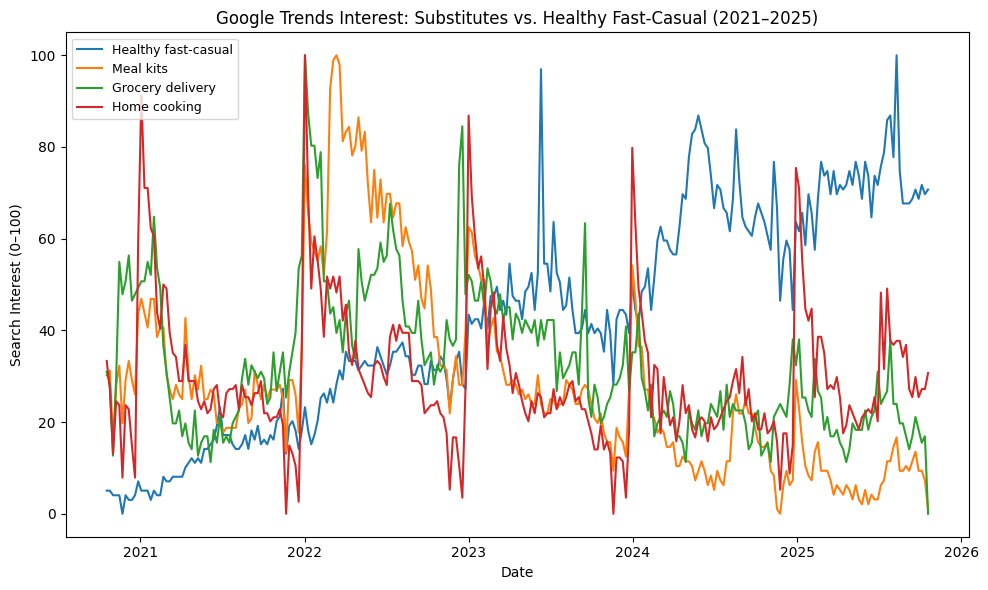

In [ ]:
# --- Define keyword groups ---
keyword_groups = {
    'Healthy fast-casual': ['healthy fast food', 'salad bowl', 'CAVA', 'Sweetgreen', 'Dig Inn'],
    'Meal kits': ['HelloFresh', 'Blue Apron', 'meal kit delivery'],
    'Grocery delivery': ['Amazon Fresh', 'Instacart', 'Whole Foods delivery'],
    'Home cooking': ['meal prep', 'healthy recipes', 'home cooking']}

# --- Function to fetch Google Trends data for a set of keywords ---
def fetch_group_trends(keywords, timeframe='today 5-y', geo='US'):
    pytrends.build_payload(keywords, timeframe=timeframe, geo=geo)

    # Fetch interest over time data
    df = pytrends.interest_over_time()

    # Drop the 'isPartial column if it exisit
    if 'isPartial' in df.columns:
        df = df.drop(columns=['isPartial'])
    return df

# --- Fetch and aggregate trends for each group ---
all_trends = {}  # dictionary to store average interest per group

for group_name, kwlist in keyword_groups.items():
    df_group = fetch_group_trends(kwlist)         # fetch raw trends
    df_group['avg_interest'] = df_group[kwlist].mean(axis=1)  # average across keywords
    all_trends[group_name] = df_group['avg_interest']         # store in dict

# --- Combine all groups into one DataFrame ---
df_trends_all = pd.DataFrame(all_trends)

# --- Normalize each series (min–max scaling to 0–100) ---
# This allows comparison across groups with different absolute interest levels
def normalize(series):
    return (series - series.min()) / (series.max() - series.min()) * 100

df_norm = df_trends_all.apply(normalize)

# --- Display the result ---
print(df_norm)

# --- Plot normalized trends over time ---
plt.figure(figsize=(10,6))
for col in df_norm.columns:
    plt.plot(df_norm.index, df_norm[col], label=col)
plt.title('Google Trends Interest: Substitutes vs. Healthy Fast-Casual (2021–2025)')
plt.xlabel('Date')
plt.ylabel('Search Interest (0–100)')
plt.legend(loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

## **5.Supplier Power Analysis**
**Purpose:**

To evaluate supplier power in the fast-casual restaurant industry by examining input cost trends using the Producer Price Index (PPI) for Farm Products. Since farm products represent a key upstream cost driver for healthy fast_casual restaurants (ingredients, produce, meat, grains), tracking PPI changes helps assess the degree to which suppliers can influence overall industry profitability.

**Data Source:**

FRED (Federal Reserve Economic Data)

WPU10: Producer Price Index - Farm Products

**Interpretation:**

The data shows that the PPI for farm products increased in 2025, reversing the stabilization seen in 2023–2024. A Rising PPI values signal increasing supplier power, as restaurants face higher costs for ingredients and raw materials. This indicates margin pressure for restaurant operators, especially smaller entrants without strong purchasing leverage or long-term supplier contracts. Larger incumbents like Chipotle or Panera can better absorb or hedge these increases through scale economies and diversified sourcing, further reinforcing their competitive advantage.


In [ ]:
# --- FRED series ID for Producer Price Index (Farm Products) ---
series_id = "WPU10"

# --- Fetch monthly PPI data from FRED ---
ppi_df = fred.get_series(series_id)
ppi_df = ppi_df.to_frame(name="PPI_index")  # convert to DataFrame and name the column

# --- Convert index to datetime ---
ppi_df.index = pd.to_datetime(ppi_df.index)

# --- Filter data to years 2021–2025 ---
ppi_df = ppi_df[(ppi_df.index.year >= 2021)]

# --- Compute annual average PPI from monthly data ---
ppi_df_yearly = ppi_df.resample("YE").mean()  # year-end frequency
ppi_df_yearly.index = ppi_df_yearly.index.year  # simplify index to just the year

# --- Drop incomplete year (2025) ---
ppi_df_yearly = ppi_df_yearly[ppi_df_yearly.index != 2025]

# --- Compute year-over-year growth (%) ---
ppi_df_yearly["yoy_growth_%"] = ppi_df_yearly["PPI_index"].pct_change() * 100

# --- Display annual PPI data ---
print("=== Annual PPI: Farm Products (2021–2024) ===")
print(ppi_df_yearly.round(2), "\n\n")

# --- Prepare data for interactive Bokeh plot ---
source = ColumnDataSource(ppi_df.reset_index().rename(columns={'index': 'Date'}))  # convert index to column

# --- Create interactive figure ---
ppi_p = figure(
    title="Producer Price Index: Farm Products (2021–2024)",
    x_axis_type="datetime",
    width=1200,
    height=600,
    x_axis_label="Year",
    y_axis_label="PPI Index Value",
    tools="pan,wheel_zoom,box_zoom,reset,save")

# --- Plot line and scatter points for PPI ---
ppi_p.line('Date', 'PPI_index', source=source, line_width=4, color='slateblue', legend_label="PPI Index")
ppi_p.scatter('Date', 'PPI_index', source=source, size=9, marker="circle", color='slateblue', alpha=0.7)

# --- Add hover tool for ---
hover = HoverTool(
    tooltips=[
        ("Date", "@Date{%Y-%m}"),
        ("PPI Index", "@PPI_index{0.00}")],
    formatters={'@Date': 'datetime'},        # format x-axis as datetime
    mode='vline')                            # vertical hover line
ppi_p.add_tools(hover)

# --- Style and format plot appearance ---
ppi_p.legend.location = "top_left"
ppi_p.title.text_font_size = "16pt"
ppi_p.xaxis.axis_label_text_font_size = "12pt"
ppi_p.yaxis.axis_label_text_font_size = "12pt"
ppi_p.xaxis.major_label_text_font_size = "12pt"
ppi_p.yaxis.major_label_text_font_size = "12pt"

# --- Display interactive plot ---
show(ppi_p)

=== Annual PPI: Farm Products (2021–2024) ===
      PPI_index  yoy_growth_%
2021     293.78           NaN
2022     326.73         11.22
2023     310.91         -4.84
2024     308.81         -0.67 





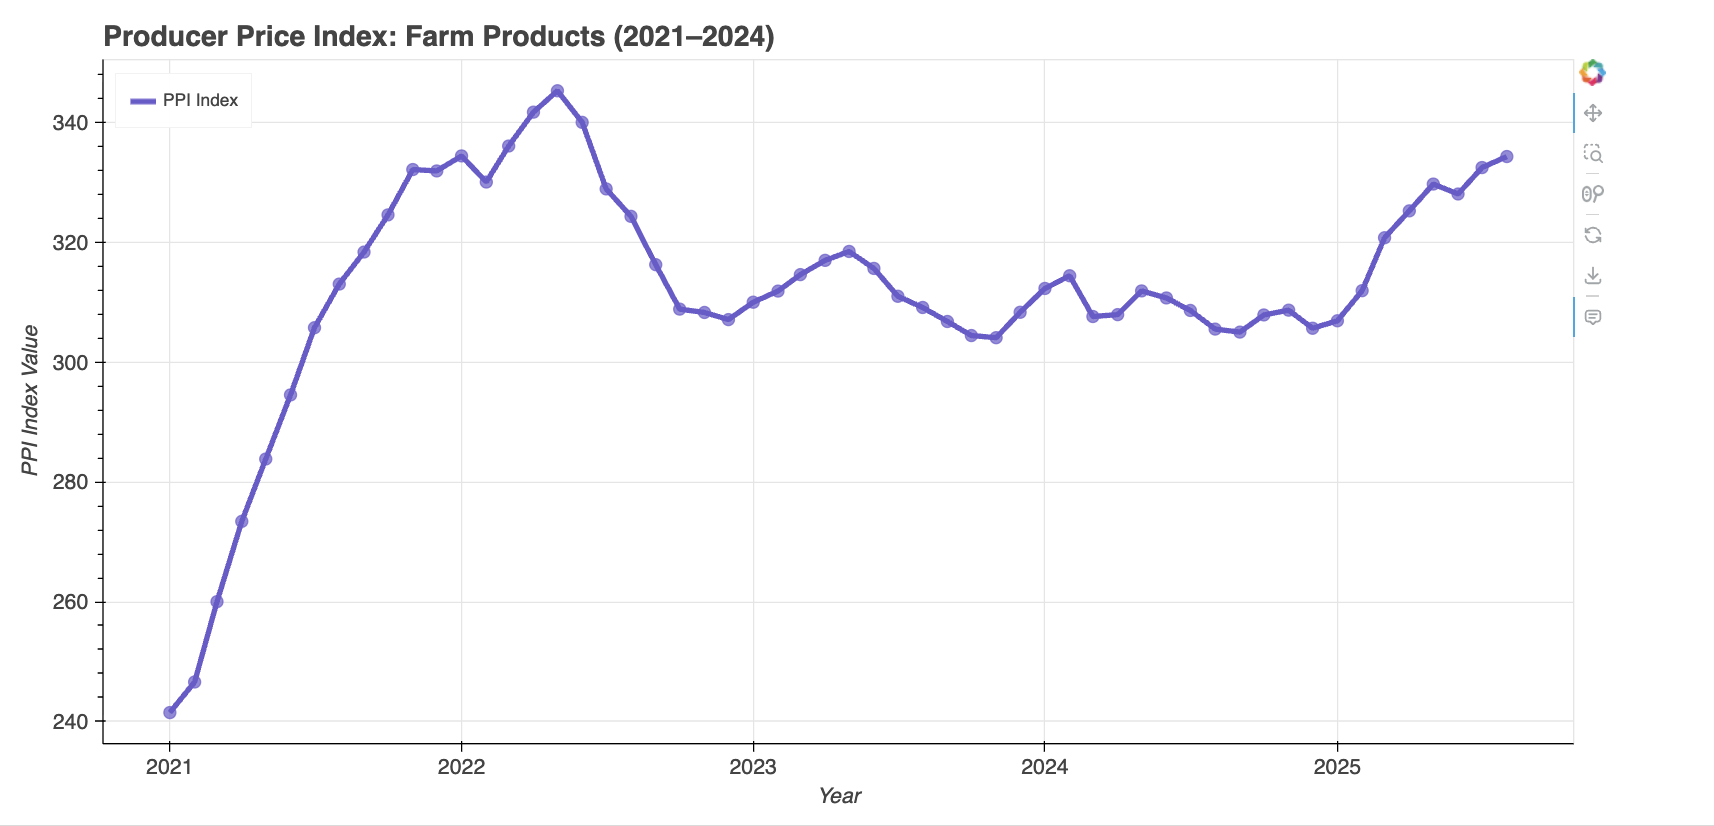

## **Conclusion**

Based on a comprehensive evaluation using economic indicators, consumer trends, and restaurant-level data, the New York healthy fast-casual market presents significant opportunities but also notable challenges:

1.Demand is strong and growing

2.Competition is intense

3.Substitution threats are moderate

4.Supplier power is increasing

5.Profitability is mixed

Overall, the New York healthy fast-casual market remains high-growth and attractive. Entry is feasible for operators who can differentiate through menu innovation, quality, health positioning, and convenience, while effectively managing costs. Price alone is insufficient; brand identity, operational efficiency, and lifestyle alignment with consumers are the true drivers of success.

## **Strategic Recommendations for Entry**

**1.Target high-opportunity ZIP codes:**

Focus on areas with high opportunity socres identified through ZIP code ranking analysis, which combine strong consumer demand with relatively favorable competition.

**2.Differentiate through quality and experience:**

Emphasize freshness, health credentials (organic, gluten-free, plant-based), and unique menu offerings.

**3.Control costs and supplier exposure:**

Establish strategic sourcing agreements or local partnerships to mitigate rising ingredient costs.

Explore vertical integration or smaller-scale batch preparation to improve margin efficiency.

**4.Leverage digital channels**

Online ordering, delivery, and app-based loyalty programs can enhance convenience and reduce friction for price-sensitive consumers. Invest in social media and Google visibility to compete with established brand awareness.

**5.Pilot and scale cautiously:**

Start with one or a few locations to validate demand, fine-tune operations, and test pricing strategy. Expand gradually once operational efficiency and brand recognition are established.

## **Limitations**
While this analysis provides a data-driven view of the New York healthy fast-casual market, but several limitations should be noted. Yelp and Google Trends data may not capture all operators or fully reflect actual sales and foot traffic. Economic indicators and financial benchmarks are largely national or chain-level, which may not represent specific conditions or smaller independent restaurants. Correlation between price and ratings assumes that Yelp ratings are a reliable proxy for customer satisfaction, while ratings can be influenced by subjective perceptions, fake reviews, or platform bias. Finally, the opportunity score formula — weighting total reviews, average ratings, and competitors — is based on arbitrary weights and assumes linear contributions from each factor. This simplification may not reflect complex market dynamics or the relative importance of each variable in driving actual business performance.

## **References**
Porter, M. E. (2004). Competitive forces (Porter’s five forces). Dictionary of Strategy: Strategic Management A-Z. https://doi.org/10.4135/9781452229805.n131